In [2]:

import numpy as np
import networkx as nx

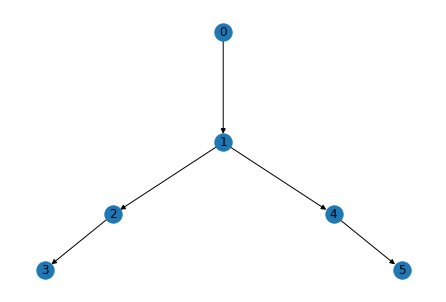

In [3]:
G = nx.DiGraph()
G.add_node(0,name="slack",smax=10,d=0)
G.add_node(1,name="step",smax=0,d=0)
G.add_node(2,name="house",smax=0,d=1.2+0.3j)
G.add_node(3,name="solar",smax=1,d=0)
G.add_node(4,name="building",smax=0,d=2.5+0.9j)
G.add_node(5,name="wind",smax=1.5,d=0)
G.add_edge(0,1,y=1/(0.0075+0.010j),thlim=2)
G.add_edge(1,2,y=1/(0.0080+0.011j),thlim=2)
G.add_edge(2,3,y=1/(0.0090+0.018j),thlim=2)
G.add_edge(1,4,y=1/(0.0040+0.004j),thlim=2)
G.add_edge(4,5,y=1/(0.0050+0.006j),thlim=2)
nx.draw(G,with_labels=True,pos=nx.spectral_layout(G))

In [4]:
A = nx.incidence_matrix(G,oriented=True)
Yp = np.diag([G.edges[k]["y"] for k in G.edges])
Ybus = A@Yp@A.T
print(Ybus)
print(np.linalg.eigvals(Ybus.real))

[[  48.         -64.j          -48.         +64.j
     0.          +0.j            0.          +0.j
     0.          +0.j            0.          +0.j        ]
 [ -48.         +64.j          216.24324324-248.45945946j
   -43.24324324 +59.45945946j    0.          +0.j
  -125.        +125.j            0.          +0.j        ]
 [   0.          +0.j          -43.24324324 +59.45945946j
    65.46546547-103.9039039j   -22.22222222 +44.44444444j
     0.          +0.j            0.          +0.j        ]
 [   0.          +0.j            0.          +0.j
   -22.22222222 +44.44444444j   22.22222222 -44.44444444j
     0.          +0.j            0.          +0.j        ]
 [   0.          +0.j         -125.        +125.j
     0.          +0.j            0.          +0.j
   206.96721311-223.36065574j  -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j            0.          +0.j
   -81.96721311 +98.36065574j   81.96721311 -98.36065574j]]
[3.55850779e+

C:\Users\carlo\AppData\Local\Temp\ipykernel_1892\2963923999.py:1: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(G,oriented=True)


In [7]:
n = G.number_of_nodes()
YN0 = Ybus[1:n,0]
YNN = Ybus[1:n,1:n]
ZNN = np.linalg.inv(YNN)
d = np.array([G.nodes[k]["d"] for k in G.nodes])
print(YN0)
print(YNN)

[-48.+64.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j]
[[ 216.24324324-248.45945946j  -43.24324324 +59.45945946j
     0.          +0.j         -125.        +125.j
     0.          +0.j        ]
 [ -43.24324324 +59.45945946j   65.46546547-103.9039039j
   -22.22222222 +44.44444444j    0.          +0.j
     0.          +0.j        ]
 [   0.          +0.j          -22.22222222 +44.44444444j
    22.22222222 -44.44444444j    0.          +0.j
     0.          +0.j        ]
 [-125.        +125.j            0.          +0.j
     0.          +0.j          206.96721311-223.36065574j
   -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j          -81.96721311 +98.36065574j
    81.96721311 -98.36065574j]]


In [8]:
def LoadFlow(sN,dN):
    v0 = 1+0j
    vN = np.ones(n-1)*v0
    for t in range(10):
        vN = ZNN@(np.conj((sN-dN)/vN)-v0*YN0)
        vT = np.hstack([v0,vN]);
        sT = vT*np.conj(Ybus@vT)
        err = np.linalg.norm(sT[1:n]-(sN-dN))
    print("Load Flow, after 10 iterations the error is",err)
    return vT


In [9]:
VT = LoadFlow(np.zeros(n-1),d[1:n])
ST = VT*np.conj(Ybus@VT)
pL = sum(ST)
print("Loss",pL)
for (k,m) in G.edges:
    Sf = Ybus[k,m]*(VT[k]-VT[m])
    print("flow",(k,m),np.abs(Sf))


Load Flow, after 10 iterations the error is 9.88471352571831e-12
Loss (0.17318313352727796+0.22089148762912414j)
flow (0, 1) 4.125588467764166
flow (1, 2) 1.3111259268830717
flow (1, 4) 2.8185600232226564
flow (2, 3) 1.7445471763153054e-14
flow (4, 5) 7.107474605133389e-15


In [10]:
import pandas as pd
results = pd.DataFrame()
results["name"] = [G.nodes[k]["name"] for k in G.nodes]
results["vpu"] = np.abs(VT)
results["ang"] = np.angle(VT)*180/np.pi
results["pnode"] = np.round(ST.real,4)
results["qnode"] = np.round(ST.imag,4)
results.head(n)


,name,vpu,ang,pnode,qnode
0,slack,1.000000,0.000000,1.3638,0.4930
1,step,0.984892,-0.578288,0.0000,-0.0000
2,house,0.982418,-0.721270,-1.2000,-0.3000
3,solar,0.996013,0.144522,0.9605,0.2782
4,building,0.978681,-0.737028,-2.5000,-0.9000
5,wind,0.988796,-0.377715,1.4183,0.4882


10.6

In [12]:
import cvxpy as cvx
smax = np.array([G.nodes[k]["smax"] for k in G.nodes])
d = np.array([G.nodes[k]["d"] for k in G.nodes])
v = cvx.Variable(n,complex=True)
s = cvx.Variable(n,complex=True)
W = cvx.Variable((n,n),complex=True)
obj = cvx.Minimize(cvx.quad_form(cvx.real(v),Ybus.real)+
cvx.quad_form(cvx.imag(v),Ybus.real))
res = [v[0] == 1.0]
M = Ybus@W
for k in G.nodes:
    res += [cvx.conj(s[k]-d[k]) == M[k,k]]
    res += [cvx.abs(v[k]-1) <= 0.05]
    res += [cvx.abs(s[k]) <= smax[k]]
    for m in G.nodes:
        res += [W[m,k] == cvx.conj(v[k])+v[m]-1]
for (k,m) in G.edges:
    res += [cvx.abs(Ybus[k,m]*(v[k]-v[m])) <= G.edges[(k,m)]
    ["thlim"]]
OPF = cvx.Problem(obj,res)
OPF.solve()
print("pL",obj.value,OPF.status)


pL 0.0405717289012366 optimal


In [16]:
s.value


array([1.32116375e+00+4.33548620e-01j, 2.69597409e-12-9.35787616e-13j,
       3.62055006e-12-1.48703159e-12j, 9.60520308e-01+2.78209748e-01j,
       3.17644361e-12-1.08719331e-12j, 1.41831593e+00+4.88241625e-01j])

In [15]:
VT = LoadFlow(s.value[1:n],d[1:n])
ST = VT*np.conj(Ybus@VT)
pL = sum(ST)
print("Loss",pL)

Load Flow, after 10 iterations the error is 7.675765536708782e-14
Loss (0.0426232431143585+0.05945112112816503j)


In [17]:
results = pd.DataFrame()
results["name"] = [G.nodes[k]["name"] for k in G.nodes]
results["vpu"] = np.abs(VT)
results["ang"] = np.angle(VT)*180/np.pi
results["pnode"] = np.round(ST.real,4)
results["qnode"] = np.round(ST.imag,4)
results.head(n)

,name,vpu,ang,pnode,qnode
0,slack,1.000000,0.000000,1.3638,0.4930
1,step,0.984892,-0.578288,0.0000,-0.0000
2,house,0.982418,-0.721270,-1.2000,-0.3000
3,solar,0.996013,0.144522,0.9605,0.2782
4,building,0.978681,-0.737028,-2.5000,-0.9000
5,wind,0.988796,-0.377715,1.4183,0.4882


In [14]:
import cvxpy as cvx
smax = np.array([G.nodes[k]["smax"] for k in G.nodes])
d = np.array([G.nodes[k]["d"] for k in G.nodes])
v = cvx.Variable(n,complex=True)
s = cvx.Variable(n,complex=True)
W = cvx.Variable((n,n),complex=True)
obj = cvx.Minimize(cvx.quad_form(cvx.real(v),Ybus.real)+
cvx.quad_form(cvx.imag(v),Ybus.real))
res = [v[0] == 1.0]
M = Ybus@W
for k in G.nodes:
    res += [cvx.conj(s[k]-d[k]) == M[k,k]]
    res += [cvx.abs(v[k]-1) <= 0.05]
    res += [cvx.abs(s[k]) <= smax[k]]
    for m in G.nodes:
        res += [W[m,k] == cvx.conj(v[k])+v[m]-1]
for (k,m) in G.edges:
    res += [cvx.abs(Ybus[k,m]*(v[k]-v[m])) <= G.edges[(k,m)]
    ["thlim"]]
OPF = cvx.Problem(obj,res)
OPF.solve()
print("pL",obj.value,OPF.status)

pL 0.040571728901998574 optimal


In [15]:
s.value

array([1.32116375e+00+4.33548620e-01j, 2.69613608e-12-9.35755007e-13j,
       3.62072528e-12-1.48701548e-12j, 9.60520309e-01+2.78209747e-01j,
       3.17657447e-12-1.08716726e-12j, 1.41831593e+00+4.88241626e-01j])

In [10]:
VT = LoadFlow(s.value[1:n],d[1:n])
ST = VT*np.conj(Ybus@VT)
pL = sum(ST)
print("Loss",pL)


Load Flow, after 10 iterations the error is 6.676047091965498e-14
Loss (0.042623243114517706+0.0594511211286638j)
